# Basic Model Interface (BMI) for streamflow prediction using Long Short-Term Memory (LSTM) networks
This Long Short-Term Memory (LSTM) network was developed for use in the [Next Generation National Water Model (Nextgen)](https://github.com/NOAA-OWP/ngen). Nextgen runs models with [Basic Model Interface (BMI)](https://bmi.readthedocs.io/en/latest/).

### These libraries should all be available in the environment.yml through the command
`conda activate bmi_lstm`
#### Make sure that the library is installed
`pip install lstm`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from netCDF4 import Dataset
from lstm import bmi_lstm  # Load module bmi_lstm (bmi_lstm.py) from lstm package.

### Set path to the project/repo folder for the LSTM model

When the LSTM Python model is used within NextGen, this folder will be in the "ngen" folder at: ngen/extern/lstm_py, and the LSTM Python package will be at: ngen/extern/{repo_name}/{package_name}.  Note that paths to required datasets will be relative to this project folder.

You will need to set your full local path `lstm_dir` to directory where you cloned the repo


In [2]:
import os, os.path
lstm_dir = os.path.expanduser('../lstm/')
os.chdir( lstm_dir )
import pandas as pd

### This sample dataset comes from [NWC-CUAHSI-Summer-Institute CAMELS_data_sample](https://github.com/NWC-CUAHSI-Summer-Institute/CAMELS_data_sample): 
Sample data for running neural hydrology examples, and others. This is just to be able to EASILY learn to use the CAMELS data with whatever modeling platform you would like. This is not intended for any purpose other than learning to use the full data.

**THIS REPOSITORY MUST BE CLONED ONTO YOUR LOCAL MACHINE**

In [3]:
basin_id = "05291000" # chose from basins available in this data sample: https://github.com/NWC-CUAHSI-Summer-Institute/CAMELS_data_sample/blob/main/sample_basins.txt
# 01013500, 01333000, 02046000, 04015330, 03010655, 03439000, 05291000, 07291000, 05057200, 06221400, 07057500, 08023080, 08267500, 09035900, 09386900, 10234500, 12010000, 10259000

In [4]:
# Load the USGS data 
# REPLACE THIS PATH WITH YOUR LOCAL FILE PATH:
file_path = f"/Users/jmframe/CAMELS_data_sample/hourly/usgs-streamflow/{basin_id}-usgs-hourly.csv"
df_runoff = pd.read_csv(file_path)
df_runoff = df_runoff.set_index("date")
df_runoff.index = pd.to_datetime(df_runoff.index)
df_runoff = df_runoff[["QObs(mm/h)"]].rename(columns={"QObs(mm/h)": "usgs_obs"})
df_runoff["model_pred"] = None

In [5]:
# REPLACE THIS PATH WITH YOUR LOCAL FILE PATH:
forcing_file_path = f"/Users/jmframe/CAMELS_data_sample/hourly/aorc_hourly/{basin_id}_1980_to_2024_agg_rounded.csv"
df_forcing = pd.read_csv(forcing_file_path)
df_forcing = df_forcing.set_index("time")
df_forcing.index = pd.to_datetime(df_forcing.index)
df_forcing = df_forcing[df_runoff.index[0]:df_runoff.index[-1]]

In [6]:
# Create an instance of the LSTM model with BMI
model_instance = bmi_lstm.bmi_LSTM()

# Initialize the model with a configuration file
model_instance.initialize(bmi_cfg_file=Path(f'../bmi_config_files/{basin_id}_nh_AORC_hourly_ensemble.yml'))

Will not print anything except errors because verbosity set to 0
self.verbose 0


/Users/jmframe/miniconda3/envs/bmi_lstm/lib/python3.10/site-packages/lstm/bmi_lstm.py:268: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_state_dict = torch.load(trai

In [7]:
# Add ensemble columns to the runoff DataFrame
for i_ens in range(model_instance.N_ENS):
    df_runoff[f"ensemble_{i_ens+1}"] = None  # Initialize ensemble columns with None

# Test the model BMI implimentation

In [8]:

# Iterate through the forcing DataFrame and calculate model predictions
print('Working, please wait...')
for idx, row in df_forcing.iterrows():
    # Extract forcing data for the current timestep
    precip = row["APCP_surface"]
    temp = row["TMP_2maboveground"]
    dlwrf = row["DLWRF_surface"]
    dswrf = row["DSWRF_surface"]
    pres = row["PRES_surface"]
    spfh = row["SPFH_2maboveground"]
    ugrd = row["UGRD_10maboveground"]
    vgrd = row["VGRD_10maboveground"]

    # Check if any of the inputs are NaN
    if np.isnan([precip, temp, dlwrf, dswrf, pres, spfh, ugrd, vgrd]).any():
        if model_instance.verbose > 0:
            print(f"Skipping timestep {idx} due to NaN values in inputs.")
        continue

    # Set the model forcings
    model_instance.set_value('atmosphere_water__liquid_equivalent_precipitation_rate', precip)
    model_instance.set_value('land_surface_air__temperature', temp)
    model_instance.set_value('land_surface_radiation~incoming~longwave__energy_flux', dlwrf)
    model_instance.set_value('land_surface_radiation~incoming~shortwave__energy_flux', dswrf)
    model_instance.set_value('land_surface_air__pressure', pres)
    model_instance.set_value('atmosphere_air_water~vapor__relative_saturation', spfh)
    model_instance.set_value('land_surface_wind__x_component_of_velocity', ugrd)
    model_instance.set_value('land_surface_wind__y_component_of_velocity', vgrd)

    # Update the model
    model_instance.update()

    # Retrieve and scale the runoff output
    dest_array = np.zeros(1)
    model_instance.get_value('land_surface_water__runoff_depth', dest_array)
    land_surface_water__runoff_depth = dest_array[0] * 1000  # Convert to mm/hr

    # Add ensemble member values to the DataFrame
    for i_ens in range(model_instance.N_ENS):
        df_runoff.loc[idx, f"ensemble_{i_ens+1}"] = model_instance.surface_runoff_mm[i_ens]  # Add individual ensemble member values


    # Add the output to the DataFrame
    df_runoff.loc[idx, "model_pred"] = land_surface_water__runoff_depth

# Ensure "model_pred" is numeric
df_runoff["model_pred"] = pd.to_numeric(df_runoff["model_pred"], errors="coerce")

# Calculate NSE for the model predictions
obs = df_runoff["usgs_obs"].dropna()
sim = df_runoff["model_pred"].dropna()

# Align indices of observation and simulation for metric calculation
common_index = obs.index.intersection(sim.index)
obs = obs.loc[common_index].values
sim = sim.loc[common_index].values

denominator = ((obs - obs.mean()) ** 2).sum()
numerator = ((sim - obs) ** 2).sum()
nse = 1 - numerator / denominator
print(f"NSE: {nse:.2f}")

Working, please wait...
NSE: 0.35


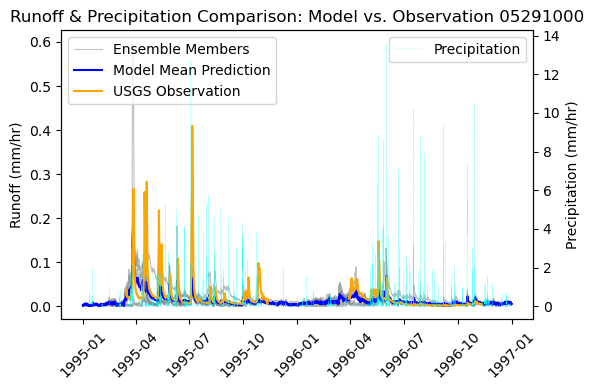

In [9]:
plot_start = "1995"
plot_end = "1996"
# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot ensemble members in grey on the primary y-axis (Runoff)
for i_ens in range(model_instance.N_ENS):
    ax1.plot(
        df_runoff.loc[plot_start:plot_end].index, 
        df_runoff.loc[plot_start:plot_end][f"ensemble_{i_ens+1}"], 
        color="grey", 
        alpha=0.5, 
        linewidth=0.8,
        label="_nolegend_" if i_ens != 0 else "Ensemble Members"  # Only add legend for the first line
    )

# Plot mean prediction and observation on primary y-axis
ax1.plot(df_runoff.loc[plot_start:plot_end].index, df_runoff.loc[plot_start:plot_end]["model_pred"], 
         label="Model Mean Prediction", color="blue")
ax1.plot(df_runoff.loc[plot_start:plot_end].index, df_runoff.loc[plot_start:plot_end]["usgs_obs"], 
         label="USGS Observation", color="orange")

# Set labels and title
ax1.set_ylabel("Runoff (mm/hr)")
ax1.set_title(f"Runoff & Precipitation Comparison: Model vs. Observation {basin_id}")

# Create secondary y-axis for precipitation
ax2 = ax1.twinx()
ax2.plot(df_forcing.loc[plot_start:plot_end].index, df_forcing.loc[plot_start:plot_end]["APCP_surface"], 
         label="Precipitation", color="cyan", linestyle="dashed", linewidth=0.15)

ax2.set_ylabel("Precipitation (mm/hr)")

# Format x-axis to show dates properly
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust based on the date range
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM-DD

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
# Adjust layout and show plot
plt.tight_layout()
plt.show()